# Homework 3

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Part 1: Email spam classification [25 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [ ]:
#your code here
import glob
print('Number of ham emails:',len(glob.glob('./email-data/ham/*.txt')))
print('Number of spam emails:',len(glob.glob('./email-data/spam/*.txt')))

Number of ham emails: 1500
Number of spam emails: 3671


**Your answers to the above questions:**

The dataset is imbalanced. This will be problematic in training the model since the model has not enough data of ham emails to learn from and may tend to predict emails to spam incorrectly.

I would address it by collecting more data points of ham emails or sampling new data points from existing ham email data to make the dataset balanced. 

**(b) Construct the documents [4 points]**
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [ ]:
import re
import string
import codecs

def make_word_list(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [ ]:
#your code here

document_ham = [make_word_list(file) for file in glob.glob('./email-data/ham/*.txt')]
document_spam = [make_word_list(file) for file in glob.glob('./email-data/spam/*.txt')]
document = document_ham + document_spam
document_label = [0 for i in range(len(document_ham))] + [1 for j in range(len(document_spam))]



**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [ ]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.8,
                                min_df=50,
                                stop_words='english')
tf = tf_vectorizer.fit_transform(document)
print("The size of the vocabulary:",tf.shape[1])

The size of the vocabulary: 1680


**(d) k-NN and random forest: Hyperparameter selection [5 points]**

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [ ]:
# K-NN
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.neighbors import KNeighborsClassifier
import numpy as np

num_folds = 5
k_fold = KFold(num_folds)
hyperparameter_settings = [2*i for i in range(1,21)]  # fill this with hyperparameter settings that you want to try

best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better

for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    # your code to train and score the training data here
    for proper_train_indices, val_indices in k_fold.split(tf):
        proper_train_features = tf[proper_train_indices]
        proper_train_labels = np.array(document_label)[proper_train_indices]
        val_features = tf[val_indices]
        val_labels = np.array(document_label)[val_indices]
        
        classifier = KNeighborsClassifier(n_neighbors=hyperparam_setting)
        classifier.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = classifier.predict(val_features)
        f1 = f1_score(val_labels, predicted_val_labels, average='weighted')
        fold_scores.append(f1)
    
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting:', best_hyperparam_setting)

Best hyperparameter setting: 4


In [ ]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

num_folds = 5
k_fold = KFold(num_folds)
hyperparameter_settings = [(max_features, min_samples_leaf) 
                           for max_features in [int(np.ceil(np.sqrt(tf.shape[1]) / 4)),
                                                int(np.ceil(np.sqrt(tf.shape[1]))),
                                                int(np.ceil(np.sqrt(tf.shape[1]) * 4))] 
                           for min_samples_leaf in [1, 2, 4, 8, 16]]  # fill this with hyperparameter settings that you want to try

best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better

for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    max_features, min_samples_leaf = hyperparam_setting

    # your code to train and score the training data here
    for proper_train_indices, val_indices in k_fold.split(tf):
        proper_train_features = tf[proper_train_indices]
        proper_train_labels = np.array(document_label)[proper_train_indices]
        val_features = tf[val_indices]
        val_labels = np.array(document_label)[val_indices]
        
        classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0)
        classifier.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = classifier.predict(val_features)
        f1 = f1_score(val_labels, predicted_val_labels, average='weighted')
        fold_scores.append(f1)
    
    cross_val_score = np.mean(fold_scores)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting:', best_hyperparam_setting)

Best hyperparameter setting: (11, 1)


**(e) Classifier testing: Precision-Recall and ROC curves [10 points]**

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the full training data.
   - Use test emails in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.)
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

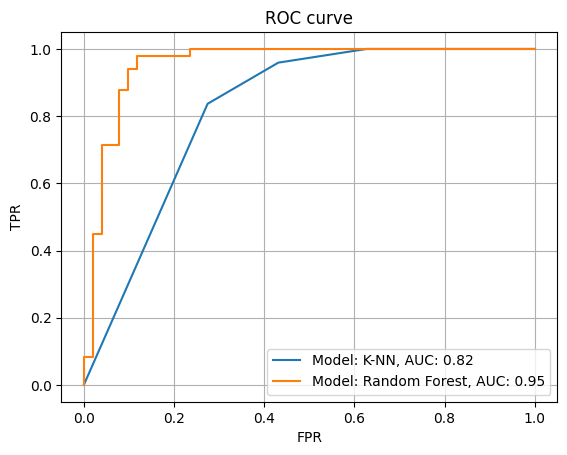

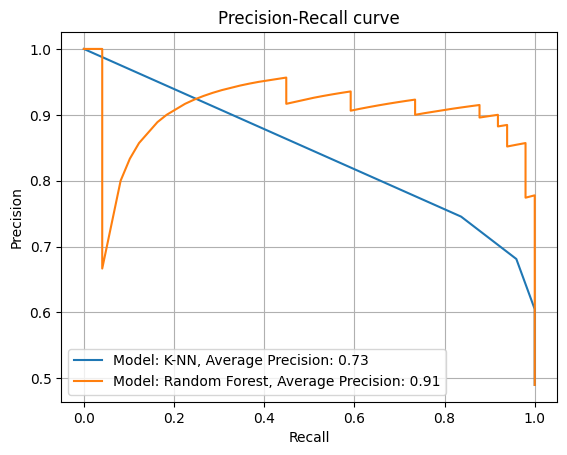

In [ ]:
#your code here
from sklearn.metrics import roc_curve, average_precision_score, precision_recall_curve
%matplotlib inline
import matplotlib.pyplot as plt


test_doc, test_label = zip(*[(make_word_list(file), 0 if file.split('.')[-2]=='ham' else 1) for file in glob.glob('./email-data/testing/*.txt')])
test_data = tf_vectorizer.transform(test_doc)
test_data = test_data.toarray()
test_label = np.array(test_label)

knn_classifier = KNeighborsClassifier(n_neighbors=4)
rf_classifier = RandomForestClassifier(max_features=11,
                                       min_samples_leaf=1)
model = [knn_classifier, rf_classifier]
model_name = ['K-NN', 'Random Forest']

for m, name in zip(model, model_name):
    m.fit(tf, np.array(document_label))
    y_score = m.predict_proba(test_data)[:,1]
    fpr, tpr, thresholds = roc_curve(test_label, y_score, pos_label=1)
    auc = np.trapz(tpr, fpr)
    plt.plot(fpr, tpr, linestyle='-', label = 'Model: {}, AUC: {:.2f}'.format(name, auc))

plt.title("ROC curve")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.show()

for m, name in zip(model, model_name):
    m.fit(tf, np.array(document_label))
    y_score = m.predict_proba(test_data)[:,1]
    precision, recall, thresholds = precision_recall_curve(test_label, y_score)
    avg_precision = average_precision_score(test_label, y_score)
    plt.plot(recall, precision, label = 'Model: {}, Average Precision: {:.2f}'.format(name, avg_precision))


plt.title("Precision-Recall curve")
plt.legend()
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.show()



**Your answers to the above questions:**

When some words in the test data do not occur in the training data, addressing this by just ignoring these words and still keep the vocabulary formed from the train data. And use the fitted CountVectorizer to transform the test documents.

I will use ROC curve for this task. Because in this task, we care more about not classifying a ham email into spam, which means we want to lower the FPR. Therefore, ROC curve is more helpful in deciding this than judging from the whole sample precision when data is imbalanced. Also, from the two plots, we could find that the ROC curve is smooth with less spike. 

Random Forest classifier with max_features = 11 and min_samples_leaf = 1 is the best classifier. Because according to the ROC curve, under all thresholds, when the FPR rate is the same, the TPR of this classifier is higher than the TPR of the best K-NN classifier. And the AUC value of this classifier is 0.95, which much higher than that of K-NN classifier(0.82). 

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Let's start with some imports.

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
        UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
        UDA_pytorch_model_transform, UDA_compute_accuracy

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



<ipython-input-48-35012220dad7>:7: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  train_images = torch.tensor([image.numpy() for image, label in train_dataset])


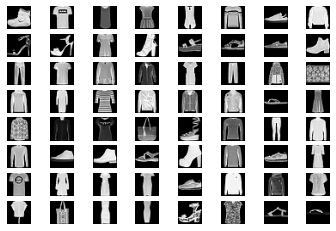

In [48]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [49]:
# write your code here
x_train = train_images[((train_labels==2) | (train_labels==6))]
y_train = torch.tensor([0 if l==2 else 1 for l in train_labels[((train_labels==2) | (train_labels==6))]])
x_test = test_images[((test_labels==2) | (test_labels==6))]
y_test = torch.tensor([0 if l==2 else 1 for l in test_labels[((test_labels==2) | (test_labels==6))]])


In [50]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [51]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [52]:
# write your code here
x_train_small = x_train[random_sample]
y_train_small = y_train[random_sample]

**(b) [9 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [58]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt', map_location='cpu'))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()
/usr/local/lib/python3.8/dist-packages/torchsummaryX/torchsummaryX.py:101: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_sum = df.sum()


,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [59]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...
[t-SNE] Computed neighbors for 1000 samples in 0.127s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929497
[t-SNE] KL divergence after 250 iterations with early exaggeration: 71.046600
[t-SNE] KL divergence after 1000 iterations: 1.063490


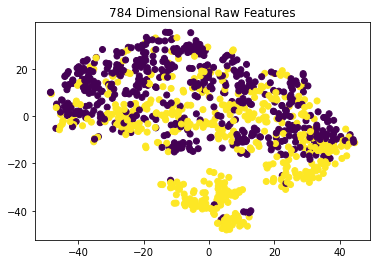

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.001s...


/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 1000 samples in 0.069s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.288849
[t-SNE] KL divergence after 1000 iterations: 0.987678


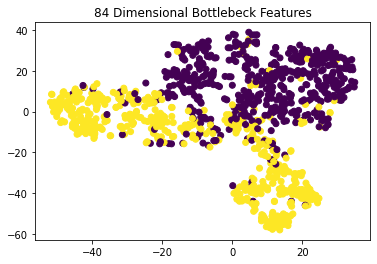

In [60]:
# write your code here
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
x_train_tsne2d = tsne.fit_transform(x_train_small.reshape(1000,-1))
plt.scatter(x_train_tsne2d[:, 0], x_train_tsne2d[:, 1], c=y_train_small)
plt.title('784 Dimensional Raw Features')
plt.show()
tsne1 = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
bottleneck_tsne2d = tsne1.fit_transform(x_train_small_bottleneck_representation)
plt.scatter(bottleneck_tsne2d[:, 0], bottleneck_tsne2d[:, 1], c=y_train_small)
plt.title('84 Dimensional Bottlebeck Features')
plt.show()

**(c) [16 points]** We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)

Test each model with corresponding **test dataset** and print the test accuracy. Also, compute and print the test accuracy of the **pre-trained convnet** (`convnet`) by using **test data**. You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   | 0.8910              | this cell stays empty|
| 5-NN             | 0.8560              | 0.8880               |
| Random forest    | 0.8765              | 0.8980               |

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [61]:
# write your code here
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)

knn_classifier_raw = KNeighborsClassifier(n_neighbors=5)
knn_classifier_bn = KNeighborsClassifier(n_neighbors=5)
rf_classifier_raw = RandomForestClassifier(n_estimators=100, random_state=0)
rf_classifier_bn = RandomForestClassifier(n_estimators=100, random_state=0)


knn_classifier_raw.fit(x_train.reshape(x_train.shape[0],-1), y_train)
predicted_knn_raw = knn_classifier_raw.predict(x_test.reshape(x_test.shape[0],-1))
knn_raw_acc = sum(predicted_knn_raw==np.array(y_test)) / y_test.shape[0]
print('Test Accuracy of 5-NN on Raw Features:', knn_raw_acc)


knn_classifier_bn.fit(x_train_bottleneck_representation, y_train)
predicted_knn_bn = knn_classifier_bn.predict(x_test_bottleneck_representation)
knn_bn_acc = sum(predicted_knn_bn==np.array(y_test)) / y_test.shape[0]
print('Test Accuracy of 5-NN on Bottleneck Features:', knn_bn_acc)


rf_classifier_raw.fit(x_train.reshape(x_train.shape[0],-1), y_train)
predicted_rf_raw = rf_classifier_raw.predict(x_test.reshape(x_test.shape[0],-1))
rf_raw_acc = sum(predicted_rf_raw==np.array(y_test)) / y_test.shape[0]
print('Test Accuracy of Random Forest on Raw Features:', rf_raw_acc)


rf_classifier_bn.fit(x_train_bottleneck_representation, y_train)
predicted_rf_bn = rf_classifier_bn.predict(x_test_bottleneck_representation)
rf_bn_acc = sum(predicted_rf_bn==np.array(y_test)) / y_test.shape[0]
print('Test Accuracy of Random Forest on Bottleneck Features:', rf_bn_acc)

predicted_cnn = np.argmax(np.array(UDA_pytorch_model_transform(convnet, x_test)[:, (2,6)]), axis=1) 
cnn_acc = sum(predicted_cnn==np.array(y_test)) / y_test.shape[0]
print('Test Accuracy of Pretrained CNN:', cnn_acc)



Test Accuracy of 5-NN on Raw Features: 0.856
Test Accuracy of 5-NN on Bottleneck Features: 0.888
Test Accuracy of Random Forest on Raw Features: 0.8765
Test Accuracy of Random Forest on Bottleneck Features: 0.898
Test Accuracy of Pretrained CNN: 0.891


Among the five models above, which model performed the best? Which model showed the lowest accuracy? For the 5-NN and random forest classifiers, is the prediction accuracy higher using bottleneck features instead of the raw features?

**Write your answers here:**

Random Forest trained on bottleneck features performs the best. 5-NN trained on raw features showed the lowest accuracy. 

The prediction accuracy is higher using bottleneck features instead of raw features for the 5-NN and random forest classifiers.



**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

Text(0, 0.5, 'TPR')

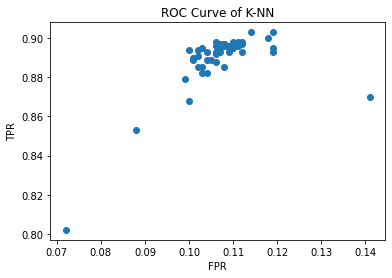

In [64]:
# write your code here
TPR = []
FPR = []

for k in range(1,51):
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(x_train_bottleneck_representation, y_train)
    predicted_labels = knn_classifier.predict(x_test_bottleneck_representation)
    TPR.append(predicted_labels[y_test==1].mean()) 
    FPR.append(predicted_labels[y_test==0].mean())

plt.scatter(FPR, TPR)
plt.title('ROC Curve of K-NN')
plt.xlabel('FPR')
plt.ylabel('TPR')



Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:**

The best value of number of nearest neighbors k that achieves the highest true positive rate but does not have more than 12.5% false positive rate is 11.



In [65]:
# write your code here (if it helps you justify your answer above)
best_k=None
best_TPR = -np.inf

for k in range(0,50):
    if FPR[k] <=0.125:
        if TPR[k] > best_TPR:
            best_TPR = TPR[k]
            best_k = k + 1
print(best_k)


11


# Part 3: Sentiment Analysis [35 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment.

**We intentionally wrote this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.** We will give full credit even if you subsample the training data. For example, you only work with 5000 randomly chosen training tweets instead of all of them (over 1 million tweets). Also, for the random forest part (the last part), you can keep track of only the most frequently occurring 1000 words (again, this is enough for full credit) and you can also set the RandomForestClassifier argument "n_jobs" to -1 to use all your CPU threads. However, do not subsample the test dataset (which is small anyways).

If you want to have practice with what it's like working with a sizable dataset though, we do encourage you to try to use as much of the training data as possible (our solution code uses the full training data in an 80-20 split between a proper training set and a validation set, just like in lectures). Note that using all the data does involve more careful data preprocessing to avoid possible memory issues. Some suggestions:

- Using your knowledge from weeks 1 and 2, you can write your own code to tokenize tweets and only include some of the tokens (e.g., only keeping the most common 1000 tokens, etc); in particular you can build your own vocabulary. As a suggestion, make vocabulary token \#0 correspond to a special padding character `"<pad>"`; this special index 0 will in fact be automatically added by the batching process for recurrent neural nets when making different tweets within the same batch have the same length. As another suggestion, make a special vocabulary token `"<unk>"` for unknown tokens that you've decided not to keep track of. For example, if you only keep track of the most common 1000 tokens, then any token that is not one of these most common 1000 gets represented as `"<unk>"`.

- For the last part, training a random forest for sentiment analysis could be very computationally expensive. If you are already subsampling the training data beforehand, then great, just work with a smaller dataset (note: you should use the same training data for both the LSTM and for the random forest so that the comparison between them is fair). If you want to still try to use the full training dataset or as much of it as possible, then we suggest that you represent the feature vectors as a sparse matrix. You might also want to set the "max_samples" argument to be something like 0.1 so that each tree uses a 10% subsample of the proper training set (with the default choice of 100 trees, across all your trees, you will likely use the vast majority of the full training set---it's just that each tree won't look at more than 10% of the proper training set). Also, simple data splitting suffices; cross-validation here would be very expensive. Moreover, it's fine to not train a random forest from scratch using the best hyperparameters found; instead just use whichever model was trained using the proper training data with the best hyperparameters found.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [2]:
# your code here
import csv
train_dataset = []
with open('./HW3-data/train.csv', encoding = 'iso8859') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        train_dataset.append((line[-1], int(line[0])))
        
positive = sum([label==1 for text,label in train_dataset])
print('Positive Sentiment Labels#: {}, Negative Sentiment Labels#: {}'.format(positive, len(train_dataset)-positive))

Positive Sentiment Labels#: 800000, Negative Sentiment Labels#: 800000


**(b) [20 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

  0%|          | 0/10 [00:00<?, ?it/s]

  Train accuracy: 0.6624
  Validation accuracy: 0.6675


 10%|█         | 1/10 [00:06<01:00,  6.76s/it]

  Train accuracy: 0.7014
  Validation accuracy: 0.6785


 20%|██        | 2/10 [00:14<00:58,  7.27s/it]

  Train accuracy: 0.7530
  Validation accuracy: 0.7290


 30%|███       | 3/10 [00:21<00:49,  7.00s/it]

  Train accuracy: 0.7794
  Validation accuracy: 0.7270


 40%|████      | 4/10 [00:27<00:40,  6.83s/it]

  Train accuracy: 0.8081
  Validation accuracy: 0.7310


 50%|█████     | 5/10 [00:34<00:34,  6.80s/it]

  Train accuracy: 0.8380
  Validation accuracy: 0.7425


 60%|██████    | 6/10 [00:41<00:28,  7.03s/it]

  Train accuracy: 0.8698
  Validation accuracy: 0.7250


 70%|███████   | 7/10 [00:48<00:20,  6.90s/it]

  Train accuracy: 0.8766
  Validation accuracy: 0.7275


 80%|████████  | 8/10 [00:55<00:13,  6.78s/it]

  Train accuracy: 0.8989
  Validation accuracy: 0.7330


 90%|█████████ | 9/10 [01:02<00:06,  6.97s/it]

  Train accuracy: 0.9120
  Validation accuracy: 0.7155


100%|██████████| 10/10 [01:09<00:00,  6.91s/it]


Test accuracy: 0.642570281124498


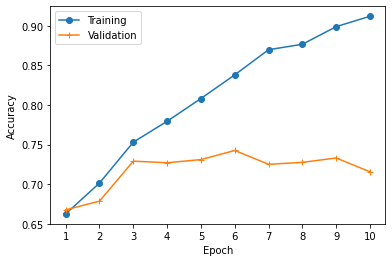

In [ ]:
# your code here
from torchtext.data import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from UDA_pytorch_utils import UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy, UDA_get_rnn_last_time_step_outputs
from torchtext.vocab import GloVe
import torch
import torch.nn as nn

# randomly draw 10000 samples
tokenizer = get_tokenizer('spacy', language='en_core_web_sm')
random_sample = np.random.permutation(len(train_dataset))[:10000]
train_subsample = np.array(train_dataset)[random_sample]

# split train and validation set
proper_train_size = int(len(train_subsample) * 0.8)
val_size = len(train_subsample) - proper_train_size
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_subsample,
                                                                  [proper_train_size,
                                                                   val_size])

# encode the train and validation set
proper_train_dataset_as_tokens = [tokenizer(str(text)) for text,label in proper_train_dataset]
vocab = build_vocab_from_iterator(proper_train_dataset_as_tokens, specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])
proper_train_encoded = [vocab(tokens) for tokens in proper_train_dataset_as_tokens]
proper_train_labels = [int(label) for text, label in proper_train_dataset]
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_encoded = [vocab(tokenizer(str(text))) for text, label in val_dataset]
val_labels = [int(label) for text, label in val_dataset]
val_dataset_encoded = list(zip(val_encoded, val_labels))

# get word embedding for vocabulary
pretrained_embedding = GloVe(name='6B', dim=100)
embedding_matrix = torch.zeros(len(vocab), pretrained_embedding.dim)
for i, token in enumerate(vocab.lookup_tokens(range(len(vocab)))):
    embedding_matrix[i] = pretrained_embedding[token]

# define the LSTM model in class
class EmbeddingLSTMLinearModel(nn.Module):
    def __init__(self, embedding_matrix, num_lstm_output_nodes, num_final_output_nodes):
        super().__init__()
        self.embedding_layer = nn.Embedding.from_pretrained(embedding_matrix)
        self.lstm_layer = nn.LSTM(embedding_matrix.shape[1], num_lstm_output_nodes)
        self.linear_layer = nn.Linear(num_lstm_output_nodes, num_final_output_nodes)

    def forward(self, texts, lengths):
        embeddings = self.embedding_layer(texts)
        rnn_last_time_step_outputs = \
            UDA_get_rnn_last_time_step_outputs(embeddings, lengths, self.lstm_layer)
        return self.linear_layer(rnn_last_time_step_outputs)

simple_lstm_model = EmbeddingLSTMLinearModel(embedding_matrix, 64, 2)

# doing parameter tuning and choose batch_size = 256, learning_rate = 0.015
num_epochs = 10 
batch_size = 256 
learning_rate = 0.015

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.Adam(simple_lstm_model.parameters(),
                                                lr=learning_rate),
                               nn.CrossEntropyLoss(), 
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               rnn=True)

# plot the train and validation accuracy through epochs
UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

# test accuracy
test_dataset = []
with open('./HW3-data/test.csv', encoding = 'iso8859') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        test_dataset.append((line[-1], int(line[0])))

test_encoded = [vocab(tokenizer(text)) for text, label in test_dataset]
test_labels = [label for text, label in test_dataset]

predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       rnn=True)

# able to achieve test accuracy of 0.6426 for this simple model
print()
print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [40]:
# your code here
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import KFold

#remove stop words
stopwords = [line.rstrip() for line in open('./HW3-data/stopwords.txt','r').readlines()]

# term frequency representation for each tweet
vectorizer = CountVectorizer(min_df=5, stop_words=stopwords, max_df=0.8)
train_rf = vectorizer.fit_transform(train_subsample[:, 0]).toarray()
train_labels = [int(label) for label in train_subsample[:, 1]] 

In [22]:
# use cross validation to select parameters that give lowest validation error
# best parameter:  max_features = 12, min_samples_leaf =2
from sklearn.ensemble import RandomForestClassifier

lowest_cross_val_error = np.inf
best_hyperparameter_setting = None

num_features = train_rf.shape[1]
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.ceil(np.sqrt(num_features) / 4)),
                                                int(np.ceil(np.sqrt(num_features))),
                                                int(np.ceil(np.sqrt(num_features) * 4))]
                           for min_samples_leaf in [1, 2, 4, 8, 16]]

kf = KFold(n_splits=5, shuffle=True, random_state=0)

for hyperparameter_setting in hyperparameter_settings:
    max_features, min_samples_leaf = hyperparameter_setting
    errors = []
    for proper_train_indices, val_indices in kf.split(train_rf):
        proper_train_features = train_rf[proper_train_indices]
        proper_train_labels = train_labels[proper_train_indices]
        val_features = train_rf[val_indices]
        val_labels = train_labels[val_indices]
        
        classifier = RandomForestClassifier(max_features=max_features,
                                            min_samples_leaf=min_samples_leaf,
                                            random_state=0)
        classifier.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = classifier.predict(val_features)
        error = np.mean(predicted_val_labels != val_labels)
        errors.append(error)
        
    cross_val_error = np.mean(errors)
    print('Hyperparameter:', hyperparameter_setting, 'cross validation error:', cross_val_error)

    if cross_val_error < lowest_cross_val_error:
        lowest_cross_val_error = cross_val_error
        best_hyperparameter_setting = hyperparameter_setting

print('Best hyperparameter:', best_hyperparameter_setting, 'cross validation error:', lowest_cross_val_error)

Hyperparameter: (12, 1) cross validation error: 0.2966
Hyperparameter: (12, 2) cross validation error: 0.2827
Hyperparameter: (12, 4) cross validation error: 0.28839999999999993
Hyperparameter: (12, 8) cross validation error: 0.31470000000000004
Hyperparameter: (12, 16) cross validation error: 0.3926
Hyperparameter: (45, 1) cross validation error: 0.3033
Hyperparameter: (45, 2) cross validation error: 0.29300000000000004
Hyperparameter: (45, 4) cross validation error: 0.3008
Hyperparameter: (45, 8) cross validation error: 0.309
Hyperparameter: (45, 16) cross validation error: 0.32300000000000006
Hyperparameter: (178, 1) cross validation error: 0.3061
Hyperparameter: (178, 2) cross validation error: 0.29640000000000005
Hyperparameter: (178, 4) cross validation error: 0.30589999999999995
Hyperparameter: (178, 8) cross validation error: 0.3155
Hyperparameter: (178, 16) cross validation error: 0.3297
Best hyperparameter: (12, 2) cross validation error: 0.2827


In [41]:
# compute test accuracy with the best parameters found
# test accuracy is 0.5783, which is lower than LSTM model
test_dataset = []
with open('./HW3-data/test.csv', encoding = 'iso8859') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        test_dataset.append((line[-1], int(line[0])))

test_rf = vectorizer.transform(np.array(test_dataset)[:, 0]).toarray()
test_labels = [int(label) for label in np.array(test_dataset)[:, 1]]

best_max_features, best_min_samples_split = best_hyperparameter_setting
final_rf_classifier = RandomForestClassifier(max_features=best_max_features,
                                             min_samples_leaf=best_min_samples_split,
                                             random_state=0)
final_rf_classifier.fit(train_rf, train_labels)
predicted_test_labels = final_rf_classifier.predict(test_rf)
test_set_accuracy = UDA_compute_accuracy(predicted_test_labels,test_labels)
print('Test accuracy:', test_set_accuracy)

Test accuracy: 0.5783132530120482
